**Generative adversarial networks**

In [ ]:
import os
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)
%matplotlib inline

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import cv2
from tqdm.notebook import tqdm

import gc
import pickle


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
SEED = 0

def set_seed(seed = SEED):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)

set_seed()

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def show_images(imgs, grid_size=(8, 8)):
    fig, ax = plt.subplots(figsize=(grid_size[0]*2, grid_size[1]*2))
    ax.set_xticks([])
    ax.set_yticks([])
    nmax = grid_size[0] * grid_size[1]
    ax.imshow(
        make_grid(imgs[:nmax], nrow=grid_size[0]).permute(1, 2, 0)
    )


In [ ]:
def clear_cache(del_objects = ['scheduler', 'criterion', 'optimizer', 'model', 'vaeautoencoder', 'cvaeautoencoder']):
  global_variables = globals()
  for del_object in del_objects:
    if del_object in global_variables:
      if hasattr(global_variables[del_object], 'to'):
        global_variables[del_object].to('cpu')
      del global_variables[del_object]
  with torch.no_grad():
    torch.cuda.empty_cache()
  gc.collect()

In [ ]:
# Clear output folder
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)


**Preprocessing/Preparing Data**

I conducted experiments using two different datasets: one recommended, consisting of approximately 3,000 images, and another larger dataset with 70,000 images (flickr-faces-70k-thumbnails-128x128/). I initially worked with the larger dataset, finding it more conducive to training a GANs model similar to the one introduced in the lab. The results were notably more realistic. However, due to the smaller size of our dataset, I explored various model variations. Given limited GPU run time resources, my primary constraint was the limited number of epochs available for training the model. Consequently, the results are less realistic, but the process provided  me with valuable insights into GANs.

In [ ]:
DATA_DIR = '/kaggle/input/faces-dataset-small'
DATA_OUT = '/kaggle/working/'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

IMAGE_SIZE = 128
BATCH_SIZE = 32
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

In [ ]:
def get_dataloader(image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, data_path=DATA_DIR, validation_split=0.1, test_split=0.1):


    train_ds = ImageFolder(data_path, transform=tt.Compose([
    tt.Resize((image_size, image_size)),
    tt.ToTensor()
    ]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dl

In [ ]:
dataloader = get_dataloader()

In [ ]:
print(f'Number of images in the dataset: {len(dataloader.dataset)}')

Number of images in the dataset: 3143


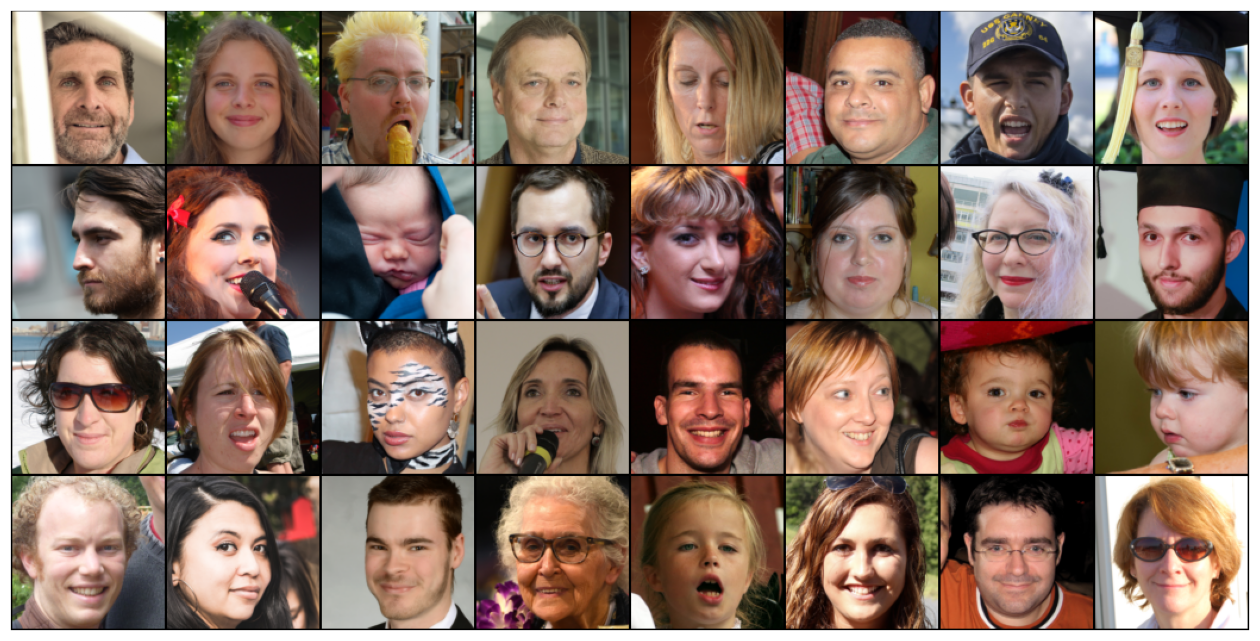

In [ ]:
test_imgs, _ = next(iter(dataloader))
show_images(test_imgs)

**Model initialization and training**

---



In [ ]:
devicedataloader = DeviceDataLoader(dataloader, DEVICE)

Using kernel_size=4 instead of an odd number like 3 or 5 is a common practice in many neural network architectures, and there are a few reasons for this:

Stride Consistency:

When using a kernel size of 4 with a stride of 2, it often results in more consistent downsampling. For example, if the input size is divisible evenly by the stride (e.g., 64x64 input with stride 2), you get exact downsampling without any spatial overlap. This can simplify the design of the network and make it more predictable.

Avoiding Padding Ambiguity:

Using an even-sized kernel with an odd-sized input or vice versa can lead to padding ambiguity. For example, with a 3x3 kernel and a stride of 2, you would need to use asymmetric padding to maintain spatial dimensions, which can complicate the architecture.

Performance Considerations:

Some deep learning frameworks, including PyTorch, are optimized for certain kernel sizes. For efficiency reasons, using commonly used kernel sizes like 3x3 or 4x4 can lead to better performance due to optimized convolution implementations.

Empirical Success:

Architectures that have been successful in various computer vision tasks, such as ResNet and VGG, often use 3x3 and 4x4 kernels. This has led to a convention of using these sizes in many architectures.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # in: 3 x 128 x 128
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 8 x 8

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 1024 x 4 x 4

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.model(x)

In [ ]:
# Instantiate the Generator
LATENT_SIZE = 32

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size=LATENT_SIZE):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512 * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512 * 4),
            nn.ReLU(True),

            # Use fractionally-strided convolution
            nn.ConvTranspose2d(512 * 4, 256 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(256 * 4, 128 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(128 * 4, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 4, 32 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),

            # Use fractionally-strided convolution
            nn.ConvTranspose2d(32 * 4, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
remove_folder_contents(DATA_OUT)
# os.rmdir(folder_path)

In [ ]:
generated_dir = DATA_OUT + '/generated'
os.makedirs(generated_dir, exist_ok=True)

In [ ]:
EPOCHS = 50
tested_epochs = [1,10, 20, 50]
TESTED_IMAGES_SIZE = 1000

In [ ]:
def generate(model, images_size):
    imgs = torch.Tensor()
    model.eval()
    with torch.no_grad():
        while images_size > 0:
            latent = torch.randn(min(images_size, BATCH_SIZE), LATENT_SIZE, 1, 1, device=DEVICE)
            imgs = torch.cat([imgs, model(latent).cpu()])
            images_size = images_size - BATCH_SIZE
    return imgs

In [ ]:
def save_samples(index, model,show=True):
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
    with torch.no_grad():
        model.eval()
        fake_images = model(latent)
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(fake_images, os.path.join(DATA_OUT, fake_fname), nrow=8)
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [ ]:
def fit(model, criterion, optimizer, epochs, save_epochs = tested_epochs):
    # Losses & scores
    losses = {
        'discriminator': [],
        'generator': []
    }
    scores = {
        'real': [],
        'fake': []
    }

    # Learning Rate Annealing
    scheduler_discriminator = lr_scheduler.StepLR(optimizer['discriminator'], step_size=10, gamma=0.5)
    scheduler_generator = lr_scheduler.StepLR(optimizer['generator'], step_size=10, gamma=0.5)


    for epoch in range(epochs):
        loss_per_epoch = {
            'discriminator': [],
            'generator': []
        }
        score_per_epoch = {
            'real': [],
            'fake': []
        }

        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(DEVICE)

            # 1.Train discriminator

            # Clear discriminator gradients
            optimizer['discriminator'].zero_grad()

            # Pass real images through discriminator
            real_preds = model['discriminator'](real_images)
#             print(real_preds.shape)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            score_per_epoch['real'].append(real_score)
            score_per_epoch['fake'].append(fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_per_epoch['discriminator'].append(loss_d.item())

            # 2.Train generator
            model['generator'].train()

            # Clear generator gradients
            optimizer['generator'].zero_grad()

            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = criterion['generator'](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer['generator'].step()
            loss_per_epoch['generator'].append(loss_g.item())

        # Learning rate annealing at the end of each epoch
        scheduler_discriminator.step()
        scheduler_generator.step()

        # Record losses & scores
        losses['generator'].append(np.mean(loss_per_epoch['generator']))
        losses['discriminator'].append(np.mean(loss_per_epoch['discriminator']))
        scores['real'].append(np.mean(score_per_epoch['real']))
        scores['fake'].append(np.mean(score_per_epoch['fake']))

        # Log losses & scores (last batch)
        print(
            'Epoch [{}/{}], gen_loss: {:.4f}, dis_loss: {:.4f}, '
            'real_score: {:.4f}, fake_score: {:.4f}'.format(
                epoch+1, epochs,
                losses['generator'][-1], losses['discriminator'][-1],
                scores['real'][-1], scores['fake'][-1]
            )
        )

        # Save results
        if save_epochs and ((epoch+1) in save_epochs):
            imgs = generate(model['generator'], TESTED_IMAGES_SIZE)
            with open(f'imgs_epoch_{epoch+1}.pkl', 'wb') as handle:
                pickle.dump(imgs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            torch.save(
                model['generator'].state_dict(),
                f'gen_epoch_{epoch+1}.weights'
            )
            torch.save(
                model['discriminator'].state_dict(),
                f'dis_epoch_{epoch+1}.weights'
            )


    return losses, scores

In [ ]:
discriminator = Discriminator()
discriminator = to_device(discriminator, DEVICE)
generator = Generator()
generator = to_device(generator, DEVICE)

GANs_model = {
    "discriminator": discriminator,
    "generator": generator
}

In [ ]:
GANs_model['discriminator']

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1024, kernel_si

In [ ]:
GANs_model['generator']

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(32, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [ ]:
LR = 0.0001

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

optimizer = {
    'discriminator': Adam(
        GANs_model['discriminator'].parameters(), lr=LR, betas=(0.5, 0.999)
    ),
    'generator': Adam(
        GANs_model['generator'].parameters(), lr=LR, betas=(0.5, 0.999)
    )
}

In [ ]:
loss_score_history = fit(GANs_model, criterion, optimizer, EPOCHS)


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/50], gen_loss: 11.0214, dis_loss: 0.5963, real_score: 0.8861, fake_score: 0.1971


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/50], gen_loss: 7.0354, dis_loss: 0.3193, real_score: 0.9337, fake_score: 0.0921


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/50], gen_loss: 7.0150, dis_loss: 0.0454, real_score: 0.9780, fake_score: 0.0182


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/50], gen_loss: 16.0890, dis_loss: 0.0874, real_score: 0.9796, fake_score: 0.0285


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/50], gen_loss: 4.3608, dis_loss: 0.7786, real_score: 0.8133, fake_score: 0.1793


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/50], gen_loss: 2.8633, dis_loss: 0.9819, real_score: 0.7063, fake_score: 0.2822


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/50], gen_loss: 2.5524, dis_loss: 0.9962, real_score: 0.6877, fake_score: 0.3037


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/50], gen_loss: 2.5049, dis_loss: 1.0295, real_score: 0.6835, fake_score: 0.3075


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/50], gen_loss: 2.6866, dis_loss: 0.9135, real_score: 0.7064, fake_score: 0.2979


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/50], gen_loss: 2.8218, dis_loss: 0.9262, real_score: 0.6999, fake_score: 0.3020


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/50], gen_loss: 2.3222, dis_loss: 0.8326, real_score: 0.6994, fake_score: 0.2906


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/50], gen_loss: 2.3921, dis_loss: 0.8353, real_score: 0.7110, fake_score: 0.2917


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/50], gen_loss: 2.4088, dis_loss: 0.9216, real_score: 0.6874, fake_score: 0.3048


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/50], gen_loss: 2.4471, dis_loss: 0.9286, real_score: 0.6932, fake_score: 0.3071


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/50], gen_loss: 2.4488, dis_loss: 0.8574, real_score: 0.7093, fake_score: 0.2918


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/50], gen_loss: 2.4723, dis_loss: 0.9028, real_score: 0.6972, fake_score: 0.3009


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/50], gen_loss: 2.7575, dis_loss: 0.8379, real_score: 0.7208, fake_score: 0.2809


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/50], gen_loss: 2.7741, dis_loss: 0.7882, real_score: 0.7289, fake_score: 0.2684


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/50], gen_loss: 2.9434, dis_loss: 0.7538, real_score: 0.7441, fake_score: 0.2536


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/50], gen_loss: 3.1017, dis_loss: 0.6979, real_score: 0.7597, fake_score: 0.2419


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/50], gen_loss: 2.0888, dis_loss: 0.6499, real_score: 0.7469, fake_score: 0.2497


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/50], gen_loss: 2.2899, dis_loss: 0.6323, real_score: 0.7573, fake_score: 0.2322


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/50], gen_loss: 2.4937, dis_loss: 0.6088, real_score: 0.7714, fake_score: 0.2276


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/50], gen_loss: 2.8383, dis_loss: 0.5621, real_score: 0.7899, fake_score: 0.2077


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/50], gen_loss: 2.6486, dis_loss: 0.5649, real_score: 0.7940, fake_score: 0.2077


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/50], gen_loss: 2.8720, dis_loss: 0.5042, real_score: 0.8070, fake_score: 0.1930


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/50], gen_loss: 2.9576, dis_loss: 0.5416, real_score: 0.8066, fake_score: 0.1901


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/50], gen_loss: 3.0542, dis_loss: 0.5198, real_score: 0.8128, fake_score: 0.1865


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/50], gen_loss: 3.1418, dis_loss: 0.4901, real_score: 0.8153, fake_score: 0.1803


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/50], gen_loss: 3.3241, dis_loss: 0.4445, real_score: 0.8338, fake_score: 0.1679


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/50], gen_loss: 2.3769, dis_loss: 0.3988, real_score: 0.8308, fake_score: 0.1650


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/50], gen_loss: 2.3762, dis_loss: 0.4022, real_score: 0.8315, fake_score: 0.1646


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/50], gen_loss: 2.4831, dis_loss: 0.4328, real_score: 0.8228, fake_score: 0.1700


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/50], gen_loss: 2.6375, dis_loss: 0.3970, real_score: 0.8396, fake_score: 0.1615


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/50], gen_loss: 2.5139, dis_loss: 0.3584, real_score: 0.8490, fake_score: 0.1484


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/50], gen_loss: 2.6341, dis_loss: 0.3637, real_score: 0.8446, fake_score: 0.1495


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/50], gen_loss: 2.7201, dis_loss: 0.3720, real_score: 0.8481, fake_score: 0.1499


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/50], gen_loss: 2.6361, dis_loss: 0.3349, real_score: 0.8599, fake_score: 0.1398


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/50], gen_loss: 2.9169, dis_loss: 0.3368, real_score: 0.8608, fake_score: 0.1333


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/50], gen_loss: 3.0115, dis_loss: 0.3182, real_score: 0.8736, fake_score: 0.1320


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/50], gen_loss: 2.5851, dis_loss: 0.2938, real_score: 0.8738, fake_score: 0.1258


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/50], gen_loss: 2.5517, dis_loss: 0.3080, real_score: 0.8666, fake_score: 0.1283


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/50], gen_loss: 2.6089, dis_loss: 0.2969, real_score: 0.8745, fake_score: 0.1284


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/50], gen_loss: 2.6173, dis_loss: 0.2893, real_score: 0.8714, fake_score: 0.1190


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/50], gen_loss: 2.5778, dis_loss: 0.2978, real_score: 0.8731, fake_score: 0.1298


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/50], gen_loss: 2.6934, dis_loss: 0.2736, real_score: 0.8797, fake_score: 0.1173


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/50], gen_loss: 2.8122, dis_loss: 0.2752, real_score: 0.8816, fake_score: 0.1166


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/50], gen_loss: 2.7783, dis_loss: 0.2626, real_score: 0.8843, fake_score: 0.1125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/50], gen_loss: 2.7834, dis_loss: 0.2785, real_score: 0.8830, fake_score: 0.1207


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/50], gen_loss: 2.7672, dis_loss: 0.2741, real_score: 0.8815, fake_score: 0.1166


In [ ]:
def show_history(history, epochs = EPOCHS):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history[0]['generator'], label='generator')
    plt.plot(range(1, epochs+1), history[0]['discriminator'], label='discriminator')
    plt.legend(loc='lower right')
    plt.title('BCE Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history[1]['real'], label='real')
    plt.plot(range(1, epochs+1), history[1]['fake'], label='fake')
    plt.legend(loc='upper left')
    plt.title('Accuracy')

    plt.show()

In [ ]:
# Saving the Object
save_path = os.path.join(DATA_OUT, 'history.pkl')
with open(save_path, 'wb') as handle:
    pickle.dump(loss_score_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Loading the Object
load_path = os.path.join(DATA_OUT, 'history.pkl')
with open(load_path, 'rb') as handle:
    loss_score_history = pickle.load(handle)

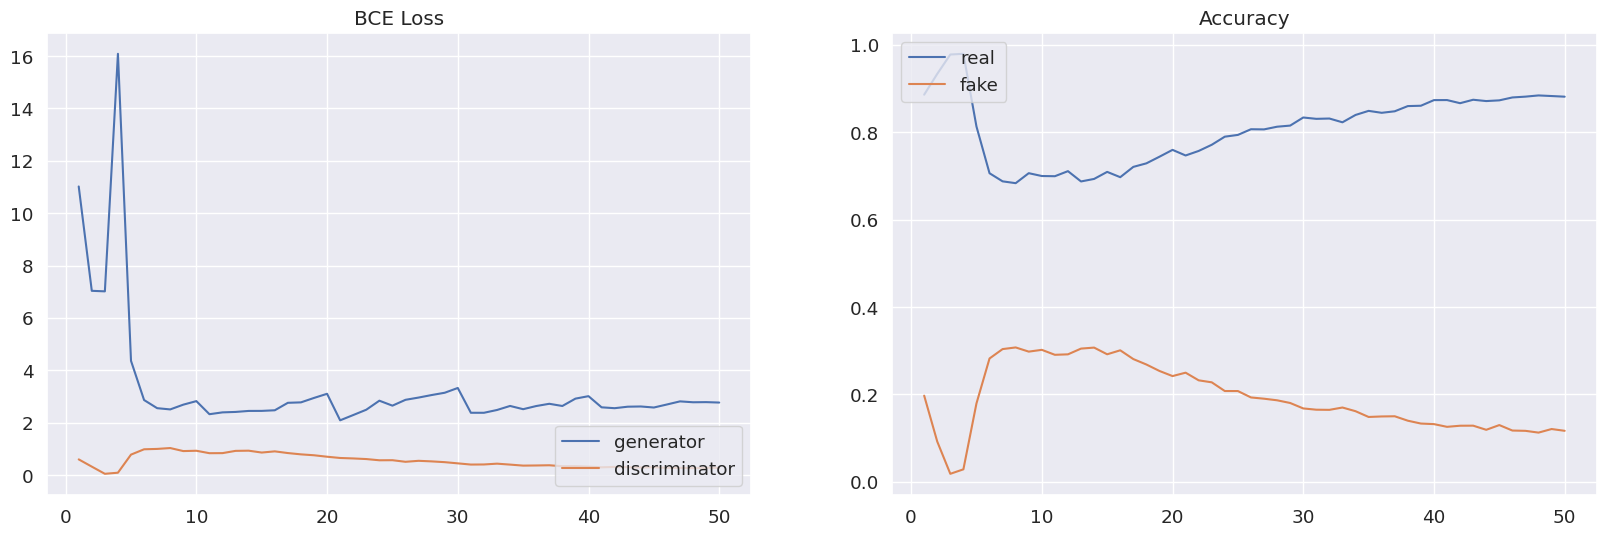

In [ ]:
show_history(loss_score_history)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

The discriminator's loss was expected to increase as the generator's loss decreased. I tried several variations of pairs of a discriminator and a generator, attempting to find a discriminator with an increasing loss.


**Generation images**

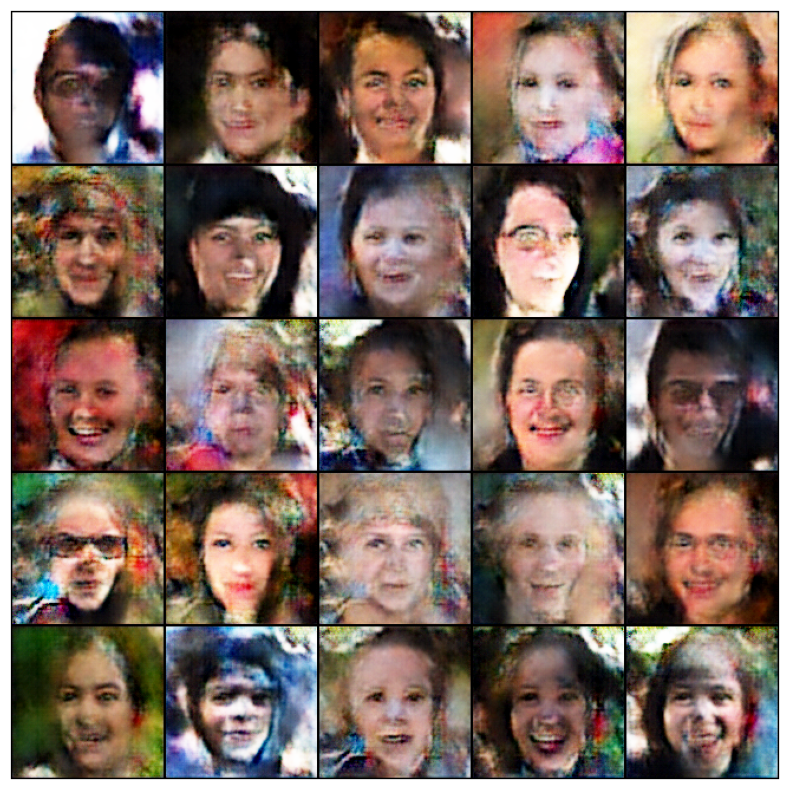

In [ ]:
N_IMAGES = 25
show_images(generate(GANs_model['generator'], N_IMAGES), grid_size=(5, 5))



To avoid checkerboard patterns, I tried fractionally-strided convolutions. Fractionally-strided convolutions are known to produce smoother results. I like the results on the skin. If I train for more epochs, based on the dynamics of scores, I believe the faces would look more realistic.

**Leave-one-out-1-NN classifier accuracy**








**Visualization of Distributions**

In [ ]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

In [ ]:
N_IMAGES = 1000

real_imgs = torch.Tensor()
for imgs, _ in dataloader:
    real_imgs = torch.cat([real_imgs, imgs])
    if real_imgs.shape[0] >= TESTED_IMAGES_SIZE:
        break

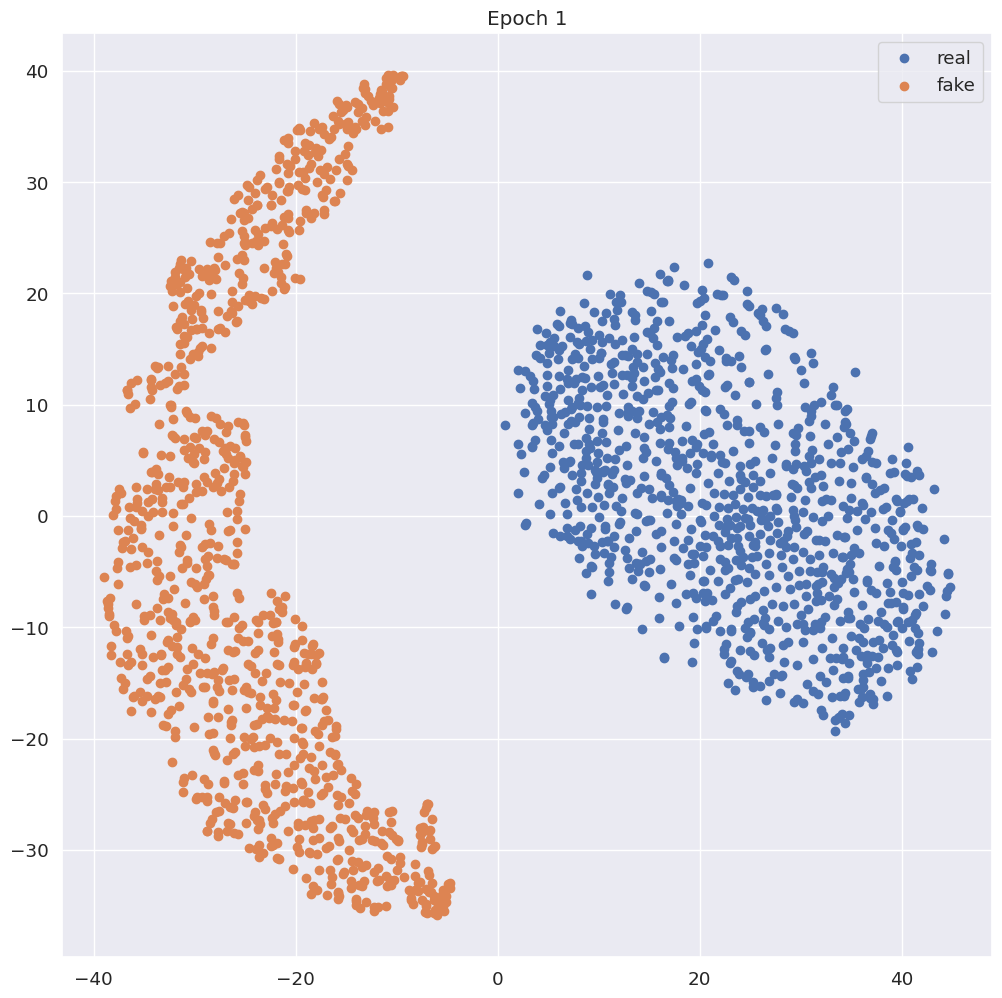

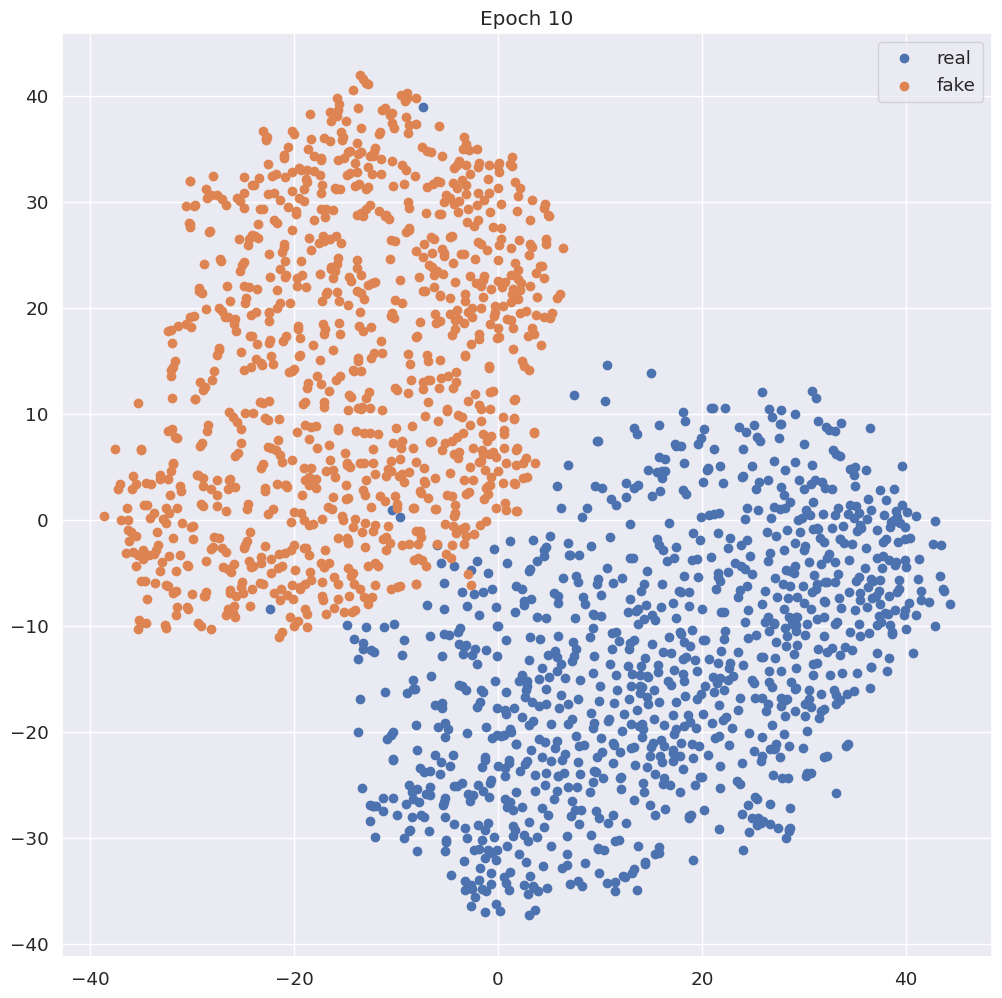

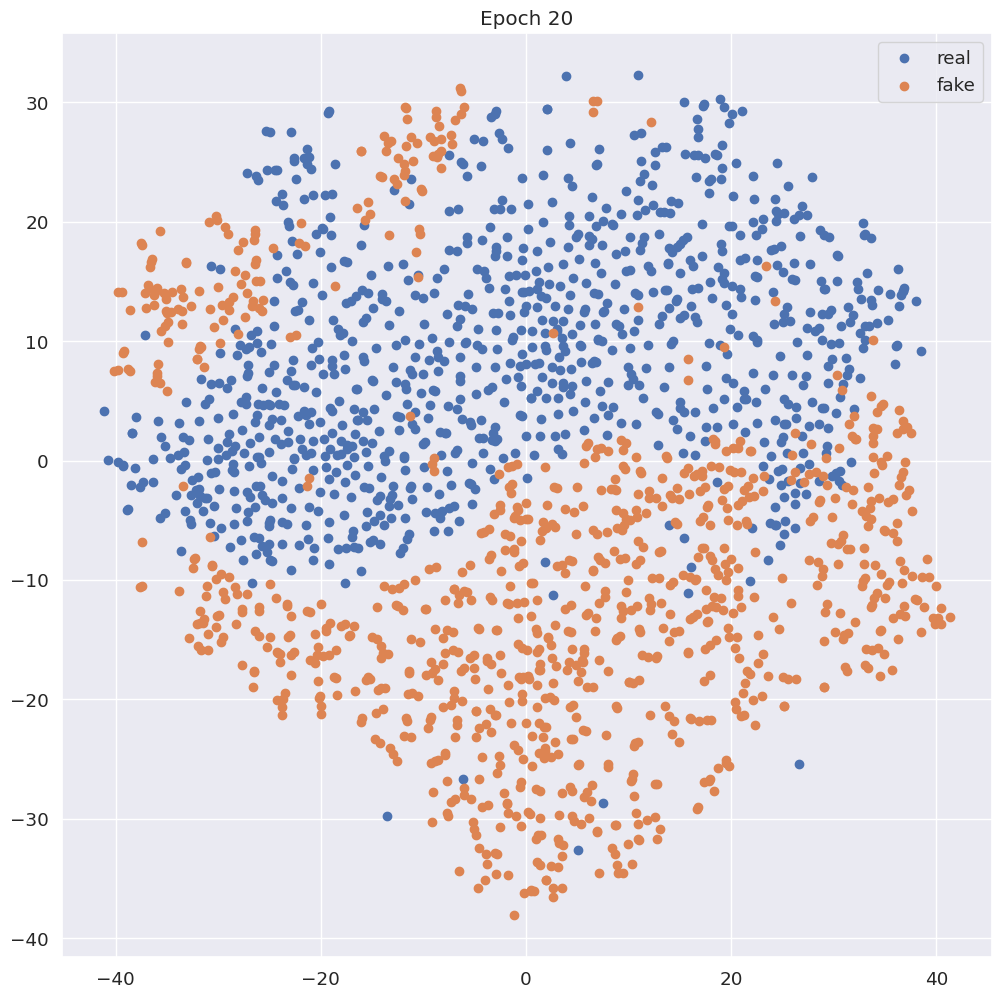

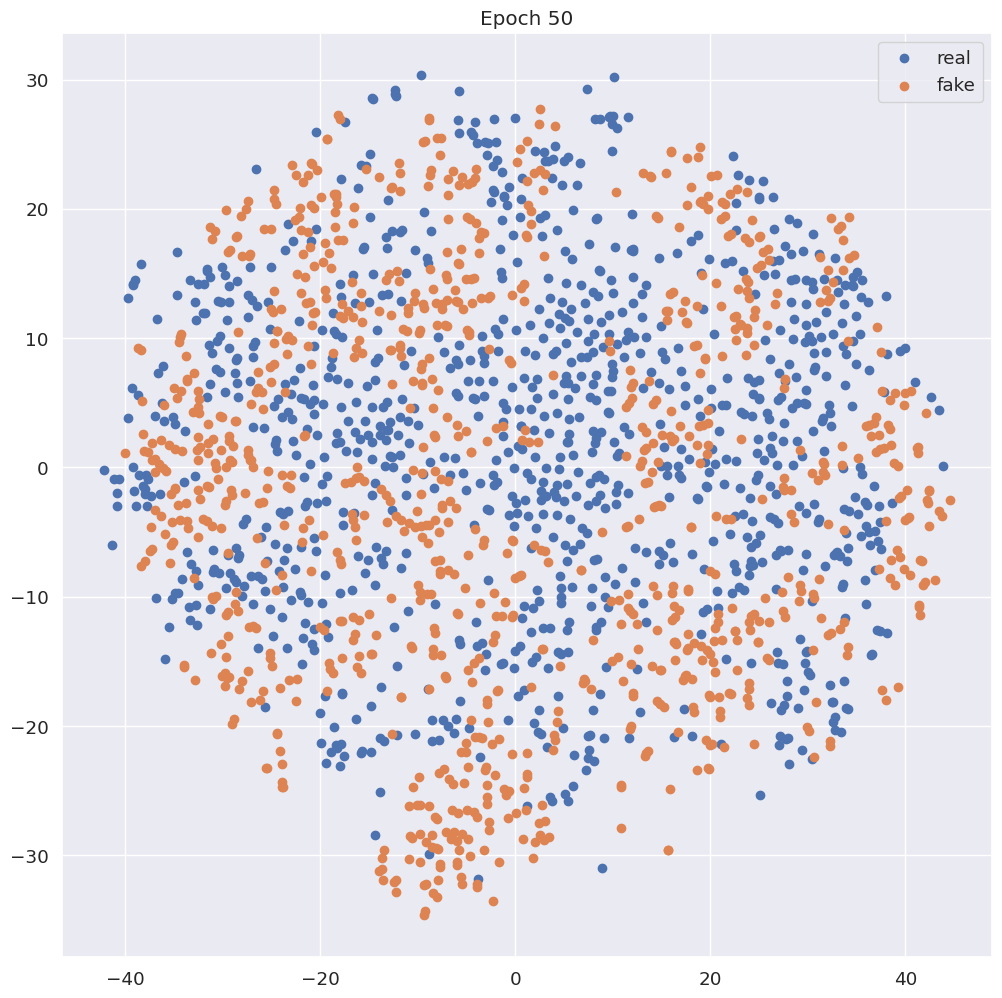

In [ ]:
ts_data = {}
for epoch in tested_epochs:
    with open(os.path.join(DATA_OUT, f'imgs_epoch_{epoch}.pkl'), 'rb') as handle:
        fake_imgs = pickle.load(handle)

    imgs_flatten = torch.cat([
        real_imgs.flatten(start_dim=1)[:TESTED_IMAGES_SIZE, :],
        fake_imgs.flatten(start_dim=1)[:TESTED_IMAGES_SIZE, :]
    ])

    ts = TSNE(random_state=SEED, verbose=0).fit_transform(imgs_flatten)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(f'Epoch {epoch}')
    plt.scatter(ts[:TESTED_IMAGES_SIZE, 0], ts[:TESTED_IMAGES_SIZE, 1], label='real')
    plt.scatter(ts[TESTED_IMAGES_SIZE:, 0], ts[TESTED_IMAGES_SIZE:, 1], label='fake')
    plt.legend()

    ts_data[epoch] = ts

Throughout the training process, I stored 1,000 generated images at specific epochs: 1, 10, 20, and 50. Subsequently, I conducted a comparison between the generated (fake) images from each of these selected epochs and real images. The t-SNE analysis for images generated at the 1st epoch revealed two distinct and separate groups, whereas the analysis for images from the 50th epoch showcased an unseparated mixture of real and generated images.

**Accuracy**

sklearn.model_selection.LeaveOneOut is a cross-validation technique provided by scikit-learn (sklearn) for evaluating machine learning models. It is a special case of k-fold cross-validation where k is set to the number of samples in the dataset. In other words, it leaves out one observation as the validation set and trains the model on the remaining n-1 observations. This process is repeated n times, each time leaving out a different observation.


LeaveOneOut is often used when you have a small dataset, and you want to make the most use of your limited data for both training and validation. It provides an exhaustive and unbiased evaluation.

In [ ]:
labels = torch.cat([torch.ones(TESTED_IMAGES_SIZE), torch.zeros(TESTED_IMAGES_SIZE)])

# build model
model = KNeighborsClassifier(n_neighbors=1)

# define cross-validation method to use
cv = LeaveOneOut()

for epoch in  tested_epochs:
    # use LOOCV to evaluate model
    accuracies = cross_val_score(
        model, ts_data[epoch], labels, scoring='accuracy', cv=cv, n_jobs=-1
    )
    print(f'Epoch {epoch} mean accuracy: {accuracies.mean()}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1 mean accuracy: 1.0
Epoch 10 mean accuracy: 0.9935
Epoch 20 mean accuracy: 0.939
Epoch 50 mean accuracy: 0.839


Throughout the training process, I stored 1,000 generated images at specific epochs: 1, 10, 20, and 50. The mean accuracy for the 1st epoch is 1.0, as real and randomly generated images are inherently distinct.

With the increasing realism of generated images, the mean accuracy is anticipated to gradually decrease towards 0.5. While 50 epochs were insufficient to reach this threshold, we observed a gradual decline in mean accuracy to 0.99, 0.93, and 0.83
